In [ ]:
!pip install geopandas

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import requests
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

# Data Prep

In [3]:
#Import Data
df = pd.read_html('https://es.wikipedia.org/wiki/Anexo:Barrios_de_la_ciudad_de_Buenos_Aires')[0]
#Rename columns
df.columns = ['Barrio','Superficie','Habitantes','Densidad','Comuna']
#Modify strings for later join
df['Barrio'] = df['Barrio'].str.upper()
df.head()

,Barrio,Superficie,Habitantes,Densidad,Comuna
0,AGRONOMÍA,"2,1 km²",34.580,8.645,Comuna 15
1,ALMAGRO,"4,1 km²",139.262,33.960,Comuna 5
2,BALVANERA,"4,4 km²",152.198,34.950,Comuna 3
3,BARRACAS,"7,6 km²",77.474,10.194,Comuna 4
4,BELGRANO,"6,8 km²",138.942,20.433,Comuna 13


#### Add lat/lon centroids

In [ ]:
#Import Data
url = "http://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson"
zones = gpd.read_file(url)
#Get centroids for each neighborhood as new columns
for i in range(0,len(zones)):
    zones.loc[i,'centroid_lon'] = zones.geometry.centroid.x.iloc[i]
    zones.loc[i,'centroid_lat'] = zones.geometry.centroid.y.iloc[i]

In [5]:
zones.head()

,barrio,comuna,perimetro,area,geometry,centroid_lon,centroid_lat
0,CHACARITA,15,7724.852955,3.115707e+06,"POLYGON ((-58.45282 -34.59599, -58.45366 -34.5...",-58.454180,-34.588369
1,PATERNAL,15,7087.513295,2.229829e+06,"POLYGON ((-58.46558 -34.59656, -58.46562 -34.5...",-58.468665,-34.597421
2,VILLA CRESPO,15,8131.857075,3.615978e+06,"POLYGON ((-58.42375 -34.59783, -58.42495 -34.5...",-58.442725,-34.598830
3,VILLA DEL PARQUE,11,7705.389797,3.399596e+06,"POLYGON ((-58.49461 -34.61487, -58.49479 -34.6...",-58.490677,-34.604247
4,ALMAGRO,5,8537.901368,4.050752e+06,"POLYGON ((-58.41287 -34.61412, -58.41282 -34.6...",-58.421745,-34.609227


#### Join Neighborhood Dataframe with lat/lon

In [ ]:
# Join neighborhood data
df_coor = df.merge(zones,how="inner", left_on="Barrio",right_on="barrio",left_index=True)

In [7]:
df_coor

,Barrio,Superficie,Habitantes,Densidad,Comuna,barrio,comuna,perimetro,area,geometry,centroid_lon,centroid_lat
4,ALMAGRO,"4,1 km²",139.262,33.960,Comuna 5,ALMAGRO,5,8537.901368,4.050752e+06,"POLYGON ((-58.41287 -34.61412, -58.41282 -34.6...",-58.421745,-34.609227
24,BALVANERA,"4,4 km²",152.198,34.950,Comuna 3,BALVANERA,3,8375.821811,4.342280e+06,"POLYGON ((-58.41192 -34.59800, -58.41029 -34.5...",-58.403062,-34.609099
29,BARRACAS,"7,6 km²",77.474,10.194,Comuna 4,BARRACAS,4,12789.791771,7.953453e+06,"POLYGON ((-58.37034 -34.63293, -58.37028 -34.6...",-58.384272,-34.646403
43,BELGRANO,"6,8 km²",138.942,20.433,Comuna 13,BELGRANO,13,20609.775397,7.999240e+06,"POLYGON ((-58.45057 -34.53561, -58.45066 -34.5...",-58.450241,-34.554763
13,BOEDO,"2,6 km²",48.520,18.662,Comuna 5,BOEDO,5,6602.510266,2.609851e+06,"POLYGON ((-58.41178 -34.63036, -58.41178 -34.6...",-58.418840,-34.629960
5,CABALLITO,"6,8 km²",183.396,25.830,Comuna 6,CABALLITO,6,10990.964471,6.851029e+06,"POLYGON ((-58.43061 -34.60705, -58.43056 -34.6...",-58.443603,-34.616825
0,CHACARITA,"3,1 km²",27.440,9.800,Comuna 15,CHACARITA,15,7724.852955,3.115707e+06,"POLYGON ((-58.45282 -34.59599, -58.45366 -34.5...",-58.454180,-34.588369
21,COGHLAN,"1,3 km²",19.177,14.752,Comuna 12,COGHLAN,12,4627.563131,1.279951e+06,"POLYGON ((-58.47242 -34.56610, -58.47296 -34.5...",-58.474944,-34.560624
23,COLEGIALES,"2,3 km²",56.998,21.922,Comuna 13,COLEGIALES,13,6374.619045,2.289774e+06,"POLYGON ((-58.44669 -34.56907, -58.44650 -34.5...",-58.450968,-34.574642
9,FLORES,"7,8 km²",150.484,18.578,Comuna 7,FLORES,7,15772.439510,8.590784e+06,"POLYGON ((-58.46041 -34.65680, -58.46090 -34.6...",-58.458268,-34.636803


In [8]:
df_coor.columns

Index(['Barrio', 'Superficie', 'Habitantes', 'Densidad', 'Comuna', 'barrio',
       'comuna', 'perimetro', 'area', 'geometry', 'centroid_lon',
       'centroid_lat'],
      dtype='object')

In [9]:
# Filter extra columns
df = df_coor[['Barrio', 'Superficie', 'Habitantes', 'Densidad', 'centroid_lon', 'centroid_lat', 'comuna']].copy()
df.head()

,Barrio,Superficie,Habitantes,Densidad,centroid_lon,centroid_lat,comuna
4,ALMAGRO,"4,1 km²",139.262,33.960,-58.421745,-34.609227,5
24,BALVANERA,"4,4 km²",152.198,34.950,-58.403062,-34.609099,3
29,BARRACAS,"7,6 km²",77.474,10.194,-58.384272,-34.646403,4
43,BELGRANO,"6,8 km²",138.942,20.433,-58.450241,-34.554763,13
13,BOEDO,"2,6 km²",48.520,18.662,-58.418840,-34.629960,5


In [ ]:
# Convert String to Float
df.Superficie = df.Superficie.str.split(" ", n = 1, expand = True)[0].str.replace(",",".").astype(float)

#### Ingreso per capita / comuna

In [11]:
# Import Income Data
url2 = 'https://www.estadisticaciudad.gob.ar/eyc/wp-content/uploads/2018/05/MT_eah_2217.xlsx'
ing = pd.read_excel(url2,sheet_name=2,skiprows=2)
ing.columns = ['comuna','Ingreso']
ing.head(2)

,comuna,Ingreso
0,1,35861.0
1,2,38787.0


In [12]:
#Add Income to each neighborhood based on "comuna" (Borough)
df = df.merge(ing,on='comuna')
df.head(3)

,Barrio,Superficie,Habitantes,Densidad,centroid_lon,centroid_lat,comuna,Ingreso
0,ALMAGRO,4.1,139.262,33.960,-58.421745,-34.609227,5,32390.0
1,BOEDO,2.6,48.520,18.662,-58.418840,-34.629960,5,32390.0
2,BALVANERA,4.4,152.198,34.950,-58.403062,-34.609099,3,27847.0


### Venues Data Neighborhoods in Buenos Aires

In [ ]:
CLIENT_ID = '####################' # your Foursquare ID
CLIENT_SECRET = '####################' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200
radius = 2000

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
bsas_venues = getNearbyVenues(names=df_coor['Barrio'],
                                   latitudes=df_coor['centroid_lat'],
                                   longitudes=df_coor['centroid_lon'])

ALMAGRO
BALVANERA
BARRACAS
BELGRANO
BOEDO
CABALLITO
CHACARITA
COGHLAN
COLEGIALES
FLORES
FLORESTA
LINIERS
MATADEROS
MONTE CASTRO
NUEVA POMPEYA
PALERMO
PARQUE AVELLANEDA
PARQUE CHACABUCO
PARQUE CHAS
PARQUE PATRICIOS
PUERTO MADERO
RECOLETA
RETIRO
SAAVEDRA
SAN TELMO
VERSALLES
VILLA CRESPO
VILLA DEL PARQUE
VILLA DEVOTO
VILLA GRAL. MITRE
VILLA LUGANO
VILLA LURO
VILLA REAL
VILLA RIACHUELO
VILLA SANTA RITA
VILLA SOLDATI
VILLA URQUIZA


In [16]:
bsas_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ALMAGRO,-34.609227,-58.421745,Las Violetas,-34.611275,-58.421057,Coffee Shop
1,ALMAGRO,-34.609227,-58.421745,El Baquiano - Fiambrería,-34.610395,-58.421248,Gourmet Shop
2,ALMAGRO,-34.609227,-58.421745,El Boliche de Roberto,-34.606932,-58.418659,Bar
3,ALMAGRO,-34.609227,-58.421745,La Catedral,-34.604958,-58.421683,Performing Arts Venue
4,ALMAGRO,-34.609227,-58.421745,El Patio de Mingo,-34.609927,-58.422652,Argentinian Restaurant


In [17]:
#Top 10 Venues Categories
bsas_venues['Venue Category'].value_counts()[:10]

Café                      61
Argentinian Restaurant    54
Pizza Place               51
Ice Cream Shop            40
Bakery                    33
Plaza                     30
Coffee Shop               28
Restaurant                22
BBQ Joint                 21
Bus Stop                  18
Name: Venue Category, dtype: int64

In [18]:
#Number of venues per Neighborhood
ven_barrio = bsas_venues.groupby('Neighborhood').count()['Venue'].reset_index()
ven_barrio 

,Neighborhood,Venue
0,ALMAGRO,38
1,BALVANERA,17
2,BARRACAS,3
3,BELGRANO,100
4,BOEDO,17
5,CABALLITO,37
6,CHACARITA,24
7,COGHLAN,13
8,COLEGIALES,38
9,FLORES,10


## Analyze Each Neighborhood

In [19]:
# one hot encoding
bsas_onehot = pd.get_dummies(bsas_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bsas_onehot['Neighborhood'] = bsas_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bsas_onehot.columns[-1]] + list(bsas_onehot.columns[:-1])
bsas_onehot = bsas_onehot[fixed_columns]

bsas_onehot.head()

,Wine Shop,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Creperie,Cultural Center,Dance Studio,...,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Street Fair,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Theater,Toll Booth,Toy / Game Store,Track,Trail,Train Station,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Whisky Bar
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
bsas_grouped = bsas_onehot.groupby('Neighborhood').mean().reset_index()
bsas_grouped

,Neighborhood,Wine Shop,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Creperie,Cultural Center,...,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Street Fair,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Theater,Toll Booth,Toy / Game Store,Track,Trail,Train Station,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Whisky Bar
0,ALMAGRO,0.00000,0.000000,0.000000,0.131579,0.00,0.000000,0.000000,0.00,0.000000,0.026316,0.000000,0.026316,0.078947,0.000000,0.000000,0.000000,0.0000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.052632,0.052632,0.000000,0.000000,0.00,0.00,0.000000,0.026316,0.000000,0.026316,0.000000,0.000000,0.000000,...,0.026316,0.000000,0.00000,0.000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
1,BALVANERA,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.058824,0.00,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.176471,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,BARRACAS,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,BELGRANO,0.00000,0.000000,0.000000,0.030000,0.00,0.000000,0.000000,0.05,0.000000,0.050000,0.000000,0.020000,0.000000,0.000000,0.020000,0.000000,0.0000,0.000000,0.010000,0.000000,0.020000,0.000000,0.030000,0.000000,0.000000,0.000000,0.070000,0.000000,0.100000,0.000000,0.00,0.00,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.020000,0.000000,0.00000,0.000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.020000,0.030000,0.00,0.000000,0.01,0.010000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.00,0.000000
4,BOEDO,0.00000,0.000000,0.000000,0.294118,0.00,0.000000,0.000000,0.00,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.00000

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


In [103]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bsas_grouped['Neighborhood']

for ind in np.arange(bsas_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bsas_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALMAGRO,Argentinian Restaurant,Ice Cream Shop,Pizza Place,Bar,Italian Restaurant,Cheese Shop,Café,Metro Station,Cafeteria,Mexican Restaurant
1,BALVANERA,Café,Fast Food Restaurant,Electronics Store,Hotel,BBQ Joint,Food,Metro Station,Gym,Bus Stop,Gym / Fitness Center
2,BARRACAS,Farmers Market,Speakeasy,Grocery Store,Fried Chicken Joint,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant,Flea Market
3,BELGRANO,Chinese Restaurant,Café,Pizza Place,Asian Restaurant,BBQ Joint,Restaurant,Argentinian Restaurant,Grocery Store,Ice Cream Shop,Sushi Restaurant
4,BOEDO,Argentinian Restaurant,Soccer Field,Intersection,Pizza Place,Breakfast Spot,Bus Stop,BBQ Joint,Cafeteria,Restaurant,Ice Cream Shop


#### Data Cafe x Comuna

In [24]:
res_grouped = bsas_onehot.groupby('Neighborhood').sum().reset_index()
# Number of Café per Neighborhood 
res_grouped[['Neighborhood','Café']]

,Neighborhood,Café
0,ALMAGRO,2
1,BALVANERA,3
2,BARRACAS,0
3,BELGRANO,7
4,BOEDO,0
5,CABALLITO,3
6,CHACARITA,2
7,COGHLAN,2
8,COLEGIALES,2
9,FLORES,2


In [25]:
res_grouped.columns.tolist()

['Neighborhood',
 'Wine Shop',
 'American Restaurant',
 'Arcade',
 'Argentinian Restaurant',
 'Art Gallery',
 'Art Museum',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'Athletics & Sports',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Bar',
 'Basketball Court',
 'Beer Bar',
 'Beer Garden',
 'Big Box Store',
 'Bike Rental / Bike Share',
 'Bistro',
 'Bookstore',
 'Breakfast Spot',
 'Brewery',
 'Burger Joint',
 'Bus Station',
 'Bus Stop',
 'Cafeteria',
 'Café',
 'Cheese Shop',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Church',
 'Clothing Store',
 'Cocktail Bar',
 'Coffee Shop',
 'Comfort Food Restaurant',
 'Concert Hall',
 'Convenience Store',
 'Creperie',
 'Cultural Center',
 'Dance Studio',
 'Deli / Bodega',
 'Department Store',
 'Dessert Shop',
 'Dim Sum Restaurant',
 'Diner',
 'Eastern European Restaurant',
 'Electronics Store',
 'Empanada Restaurant',
 'English Restaurant',
 'Exhibit',
 'Factory',
 'Falafel Restaurant',
 'Farmers Market',
 'Fast Food Restaurant',
 'Flea Market',
 'F

In [26]:
# Join Neighborhood with Venues
dd=df.merge(res_grouped,left_on='Barrio',right_on='Neighborhood')
# Estimated Potential Market
dd['Market'] = dd['Habitantes']*dd['Ingreso']
dd

,Barrio,Superficie,Habitantes,Densidad,centroid_lon,centroid_lat,comuna,Ingreso,Neighborhood,Wine Shop,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,...,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Street Fair,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Theater,Toll Booth,Toy / Game Store,Track,Trail,Train Station,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Whisky Bar
0,ALMAGRO,4.1,139.262,33.960,-58.421745,-34.609227,5,32390.0,ALMAGRO,0,0,0,5,0,0,0,0,0,1,0,1,3,0,0,0,0,1,0,0,0,0,0,0,0,1,2,2,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,BOEDO,2.6,48.520,18.662,-58.418840,-34.629960,5,32390.0,BOEDO,0,0,0,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,BALVANERA,4.4,152.198,34.950,-58.403062,-34.609099,3,27847.0,BALVANERA,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,BARRACAS,7.6,77.474,10.194,-58.384272,-34.646403,4,26869.0,BARRACAS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NUEVA POMPEYA,6.2,63.276,10.373,-58.418882,-34.650515,4,26869.0,NUEVA POMPEYA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,PARQUE PATRICIOS,3.7,40.885,10.759,-58.401675,-34.637550,4,26869.0,PARQUE PATRICIOS,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,BELGRANO,6.8,138.942,20.433,-58.450241,-34.554763,13,42140.0,BELGRANO,0,0,0,3,0,0,0,5,0,5,0,2,0,0,2,0,0,0,1,0,2,0,3,0,0,0,7,0,10,0,0,...,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,3,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0
7,COLEGIALES,2.3,56.998,21.922,-58.450968,-34.574642,13,42140.0,COLEGIALES,0,0,0,3,0,0,0,0,1,1,0,2,0,1,2,0,0,0,0,0,0,1,1,1,0,0,2,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8,CABALLITO,6.8,183.396,25.830,-58.443603,-34.616825,6,38118.0,CABALLITO,0,0,0,2,0,0,0,0,0,0,0,3,0,1,0,0,0,0,2,0,0,0,1,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
9,CHACARITA,3.1,27.440,9.800,-58.454180,-34.588369,15,33676.0,CHACARITA,0,0,0,2,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1


In [ ]:
# Ciudad de Buenos Aires latitude and longtitude. Manually extracted via google search
latitude = -34.6131516 
longitude = -58.3772316

In [29]:
# create map
map_bsas = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(dd['centroid_lat'], dd['centroid_lon'], dd['Barrio']):
    label = folium.Popup(str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.9).add_to(map_bsas)
       
map_bsas

### Plots

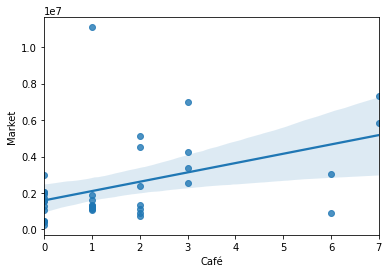

In [30]:
sns.regplot('Café','Market',dd)

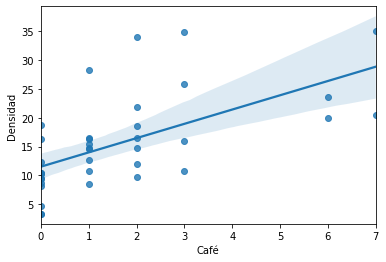

In [31]:
sns.regplot('Café','Densidad',dd)

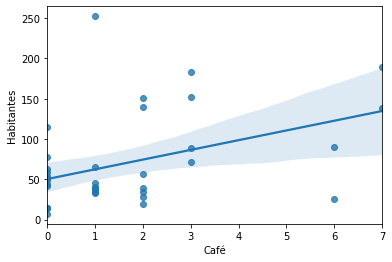

In [32]:
sns.regplot('Café','Habitantes',dd)

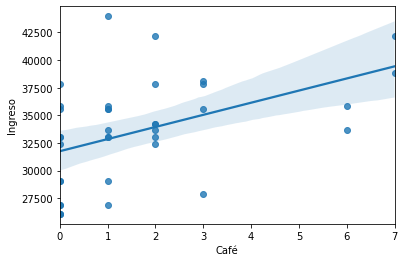

In [33]:
sns.regplot('Café','Ingreso',dd)

In [94]:
# Df subset for clustering
bsas_subs = dd[['Neighborhood','Habitantes','Ingreso','Café']].copy()
bsas_subs.head(2)

,Neighborhood,Habitantes,Ingreso,Café
0,ALMAGRO,139.262,32390.0,2
1,BOEDO,48.520,32390.0,0


In [ ]:
columns=['Habitantes','Ingreso','Café']

# Cluster Neighborhoods
Run k-means to cluster the neighborhood into 3 clusters.

In [96]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit_transform(bsas_subs[columns])

array([[0.5391583 , 0.3531154 , 0.28571429],
       [0.16925385, 0.3531154 , 0.        ],
       [0.59189114, 0.0992456 , 0.42857143],
       [0.28728313, 0.04459346, 0.        ],
       [0.22940582, 0.04459346, 0.        ],
       [0.13813022, 0.04459346, 0.14285714],
       [0.53785384, 0.89796032, 1.        ],
       [0.20381392, 0.89796032, 0.28571429],
       [0.71906796, 0.67320481, 0.42857143],
       [0.08332246, 0.42497904, 0.28571429],
       [0.13237428, 0.42497904, 0.14285714],
       [0.33776986, 0.42497904, 0.85714286],
       [0.04963883, 0.65761386, 0.28571429],
       [0.18231069, 0.65761386, 0.        ],
       [0.33573572, 0.65761386, 0.42857143],
       [0.58490412, 0.45437273, 0.28571429],
       [0.13237428, 0.45437273, 0.28571429],
       [0.13237428, 0.39066778, 0.14285714],
       [0.11244456, 0.39066778, 0.28571429],
       [0.0292607 , 0.39066778, 0.        ],
       [0.10622391, 0.39066778, 0.14285714],
       [0.02966834, 0.39066778, 0.        ],
       [0.

In [ ]:
df_scaled = pd.DataFrame(mm_scaler.fit_transform(bsas_subs[columns]))
df_scaled.columns = columns

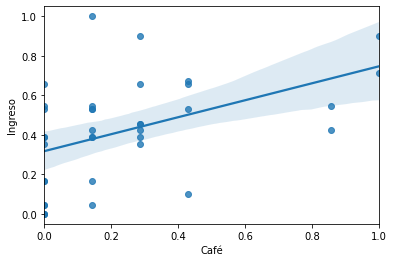

In [99]:
sns.regplot('Café','Ingreso',df_scaled)

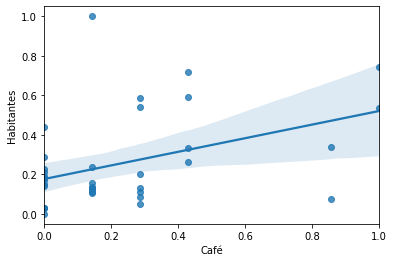

In [98]:
sns.regplot('Café','Habitantes',df_scaled)

In [100]:
# set number of clusters
kclusters = 3

#Sin Scale
# kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bsas_subs.drop('Neighborhood',1))


# # run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_scaled)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 1, 0, 0, 0, 1, 2, 1, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [47]:
# Review df's
dd.head(3)

,Barrio,Superficie,Habitantes,Densidad,centroid_lon,centroid_lat,comuna,Ingreso,Neighborhood,Wine Shop,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,...,Sandwich Place,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Street Fair,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Theater,Toll Booth,Toy / Game Store,Track,Trail,Train Station,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Whisky Bar
0,ALMAGRO,4.1,139.262,33.960,-58.421745,-34.609227,5,32390.0,ALMAGRO,0,0,0,5,0,0,0,0,0,1,0,1,3,0,0,0,0,1,0,0,0,0,0,0,0,1,2,2,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,BOEDO,2.6,48.520,18.662,-58.418840,-34.629960,5,32390.0,BOEDO,0,0,0,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,BALVANERA,4.4,152.198,34.950,-58.403062,-34.609099,3,27847.0,BALVANERA,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
neighborhoods_venues_sorted.head(3)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,ALMAGRO,Argentinian Restaurant,Ice Cream Shop,Pizza Place,Bar,Italian Restaurant,Cheese Shop,Café,Metro Station,Cafeteria,Mexican Restaurant
1,0,BALVANERA,Café,Fast Food Restaurant,Electronics Store,Hotel,BBQ Joint,Food,Metro Station,Gym,Bus Stop,Gym / Fitness Center
2,2,BARRACAS,Farmers Market,Speakeasy,Grocery Store,Fried Chicken Joint,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant,Flea Market


In [105]:
df_merged = dd.merge(neighborhoods_venues_sorted.set_index('Neighborhood'), left_on='Barrio', right_on='Neighborhood')

df_merged.head() 

,Barrio,Superficie,Habitantes,Densidad,centroid_lon,centroid_lat,comuna,Ingreso,Neighborhood,Wine Shop,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,...,Social Club,South American Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Street Fair,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Theater,Toll Booth,Toy / Game Store,Track,Trail,Train Station,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Whisky Bar,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALMAGRO,4.1,139.262,33.960,-58.421745,-34.609227,5,32390.0,ALMAGRO,0,0,0,5,0,0,0,0,0,1,0,1,3,0,0,0,0,1,0,0,0,0,0,0,0,1,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Argentinian Restaurant,Ice Cream Shop,Pizza Place,Bar,Italian Restaurant,Cheese Shop,Café,Metro Station,Cafeteria,Mexican Restaurant
1,BOEDO,2.6,48.520,18.662,-58.418840,-34.629960,5,32390.0,BOEDO,0,0,0,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Argentinian Restaurant,Soccer Field,Intersection,Pizza Place,Breakfast Spot,Bus Stop,BBQ Joint,Cafeteria,Restaurant,Ice Cream Shop
2,BALVANERA,4.4,152.198,34.950,-58.403062,-34.609099,3,27847.0,BALVANERA,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,Café,Fast Food Restaurant,Electronics Store,Hotel,BBQ Joint,Food,Metro Station,Gym,Bus Stop,Gym / Fitness Center
3,BARRACAS,7.6,77.474,10.194,-58.384272,-34.646403,4,26869.0,BARRACAS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Farmers Market,Speakeasy,Grocery Store,Fried Chicken Joint,Food Truck,Food Service,Food & Drink Shop,Food,Fondue Restaurant,Flea Market
4,NUEVA POMPEYA,6.2,63.276,10.373,-58.418882,-34.650515,4,26869.0,NUEVA POMPEYA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,Pizza Place,Grocery Store,Electronics Store,Department Store,Fast Food Restaurant,Train Station,Sports Club,Plaza,Diner,Dim Sum Restaurant


Finally, let's visualize the resulting clusters

In [108]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['centroid_lat'], df_merged['centroid_lon'], df_merged['Barrio'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

#### Analizar Clusters (4)

In [51]:
df_scaled.head(3)

,Habitantes,Market,Café
0,0.539158,0.392881,0.285714
1,0.169254,0.121797,0.000000
2,0.591891,0.367754,0.428571


In [ ]:
clust_an = df_merged[['Neighborhood','Habitantes','Densidad','Market','Café', 'Cluster Labels']]

In [ ]:
#Scaled
clust_an = df_scaled.merge(df_merged[['Neighborhood','Cluster Labels']],left_index=True, right_index=True)

In [77]:
clust_an.head(3)

,Market,Café,Neighborhood,Cluster Labels
0,0.392881,0.285714,ALMAGRO,2
1,0.121797,0.000000,BOEDO,0
2,0.367754,0.428571,BALVANERA,0


In [111]:
# Compare each cluster 
clust_an.groupby('Cluster Labels').mean()

,Habitantes,Ingreso,Café
Cluster Labels,,,
0,0.269494,0.540356,0.333333
1,0.273616,0.433625,0.155844
2,0.240647,0.343990,0.235294


From the table we can infer that:


*   Cluster 0 High Income, High Café number. 
*   Cluster 1 Medium to High Income, Lower Café number.
*   Cluster 2 Lower Income.


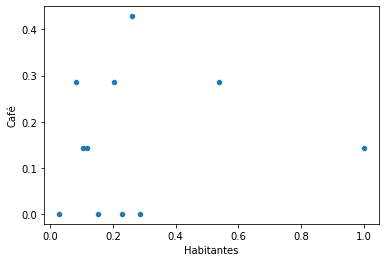

In [118]:
# Check Population/Café for Cluster 1
clust_an.loc[clust_an['Cluster Labels'] == 1].plot.scatter('Habitantes','Café')

In [116]:
# Select the top 2 candidates from the cluster, ordered by Income
clust_an.loc[clust_an['Cluster Labels'] == 1].sort_values('Ingreso',ascending=False).head(2)

,Habitantes,Ingreso,Café,Neighborhood,Cluster Labels
25,1.000000,1.00000,0.142857,PALERMO,1
7,0.203814,0.89796,0.285714,COLEGIALES,1


Final Map

In [122]:
selected_cluster = 1

candidatos =   df_merged.loc[df_merged['Cluster Labels'] == selected_cluster]
# create map
map_selected = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(candidatos['centroid_lat'], candidatos['centroid_lon'], candidatos['Barrio'], candidatos['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_selected)
       
map_selected